# AB test 통계 검정 코드 
## abtest_auto() -> 이 함수는 AB test group 수에 따른 통계 검정 방식 자동 대응

1. AB test group 2 개인 경우 -> Z-test, chi-square, bayesian
2. AB test group 3 개인 경우 -> Z-test(다중보정), chi-square, bayesian

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# ✅ 전체 float 출력 포맷 소수점 4자리로 고정 (현재 세션에만 적용. python 다시 시작하면 다시 설정해줘야 함.)
pd.set_option('display.float_format', '{:.4f}'.format)

def abtest_auto(groups, successes, trials, metric_name="Metric", samples=100_000):
    failures = trials - successes
    conversion_rates = successes / trials

    print("\n" + "#"*70)
    print(f"📊 {metric_name}\n" + "#"*70)

    group_summary = pd.DataFrame({
        'Group': groups,
        'Successes': successes,
        'Trials': trials,
        'Conversion Rate': pd.Series(conversion_rates).map(lambda x: f"{x*100:.2f}%")
    })
    print("\n✅ Group Summary (Successes, Trials, Conversion Rate)")
    display(group_summary)
    print(f"\n{'='*60}")

    if len(groups) == 2:
        # ✅ Z-test (2개 그룹)
        count = np.array([successes[0], successes[1]])
        nobs = np.array([trials[0], trials[1]])
        zstat, pval = proportions_ztest(count, nobs)
        print("\n✅ Z-test (2 groups)")
        print(f"- Z statistic: {zstat:.4f}")
        print(f"- p-value: {pval:.4f}")
        print(f"\n{'='*60}")

        # ✅ Chi-square test (2x2 contingency table)
        contingency = np.array([
            [successes[0], failures[0]],
            [successes[1], failures[1]]
        ])
        chi2, chi_p, _, _ = chi2_contingency(contingency)
        print("\n✅ Chi-square Test (2x2)")
        print(f"- Chi2 statistic: {chi2:.4f}")
        print(f"- p-value: {chi_p:.4f}")
        print(f"\n{'='*60}")

    else:
        # ✅ Chi-square test (3개 이상)
        contingency_table = np.array([successes, failures]).T
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        print("\n✅ Chi-square Test")
        print(f"- Chi2 statistic: {chi2:.4f}")
        print(f"- p-value: {p_value:.4f}")
        print(f"\n{'='*60}")

        # ✅ 사후 Pairwise Z-test (Holm-Bonferroni 보정, 빈도주의 보수적 방식)
        pairwise_results, pairs = [], []
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                count = np.array([successes[i], successes[j]])
                nobs = np.array([trials[i], trials[j]])
                _, p = proportions_ztest(count, nobs)
                pairwise_results.append(p)
                pairs.append(f"{groups[i]} vs {groups[j]}")

        reject, pvals_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='holm')
        results_df = pd.DataFrame({
            'Comparison': pairs,
            'Uncorrected p-value': pairwise_results,
            'Corrected p-value (Holm)': pvals_corrected,
            'Significant': reject
        })
        print("\n✅ Pairwise Z-test (Holm-Bonferroni):")
        display(results_df)
        print(f"\n{'='*60}")


        # ✅ 사후 Pairwise Z-test (FDR 보정, 빈도주의 유연한 방식)
        reject_fdr, pvals_fdr_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='fdr_bh')
        results_df_fdr = pd.DataFrame({
            'Comparison': pairs,
            'Uncorrected p-value': pairwise_results,
            'Corrected p-value (FDR)': pvals_fdr_corrected,
            'Significant (FDR)': reject_fdr
        })
        print("\n✅ Pairwise Z-test (FDR - Benjamini-Hochberg):")
        display(results_df_fdr)
        print(f"\n{'='*60}")

    # ✅ Bayesian analysis (공통)
    posterior_samples = {
        group: np.random.beta(1 + success, 1 + fail, samples)
        for group, success, fail in zip(groups, successes, failures)
    }

    plt.figure(figsize=(12, 7))
    for group in groups:
        sns.kdeplot(posterior_samples[group], label=f'Group {group}')
    plt.title('Posterior Distributions of Conversion Rates', fontsize=16)
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"\n{'='*60}")

    # ✅ 각 그룹이 best일 확률
    best_group_count = {group: 0 for group in groups}
    for i in range(samples):
        best_group = max(posterior_samples, key=lambda g: posterior_samples[g][i])
        best_group_count[best_group] += 1

    print("\n✅ Bayesian: Probability that each group is best")
    for group, count in best_group_count.items():
        prob = count / samples
        print(f"Probability that {group} is the best: {prob:.2%}")
    print(f"\n{'='*60}")

    # ✅ 쌍별 우위 확률
    pairwise_bayes = []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            prob = np.mean(posterior_samples[g1] > posterior_samples[g2])
            pairwise_bayes.append({
                'Comparison': f"{g1} > {g2}",
                'P(Group1 > Group2)': prob,
                'P(Group1 < Group2)': 1 - prob
            })
    df_bayes = pd.DataFrame(pairwise_bayes)
    print("\n✅ Bayesian Pairwise Superiority Probabilities:")
    display(df_bayes)
    print(f"\n{'='*60}")

# 2-1. 실험 결과 통계 검정
실험 참여자 전체를 모수로 각 액션별 전환율 지표 계산


######################################################################
📊 Total PCID to Sell Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,32007,385312,8.31%
1,B,40703,42586,95.58%




✅ Z-test (2 groups)
- Z statistic: -455.0472
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 207061.7857
- p-value: 0.0000



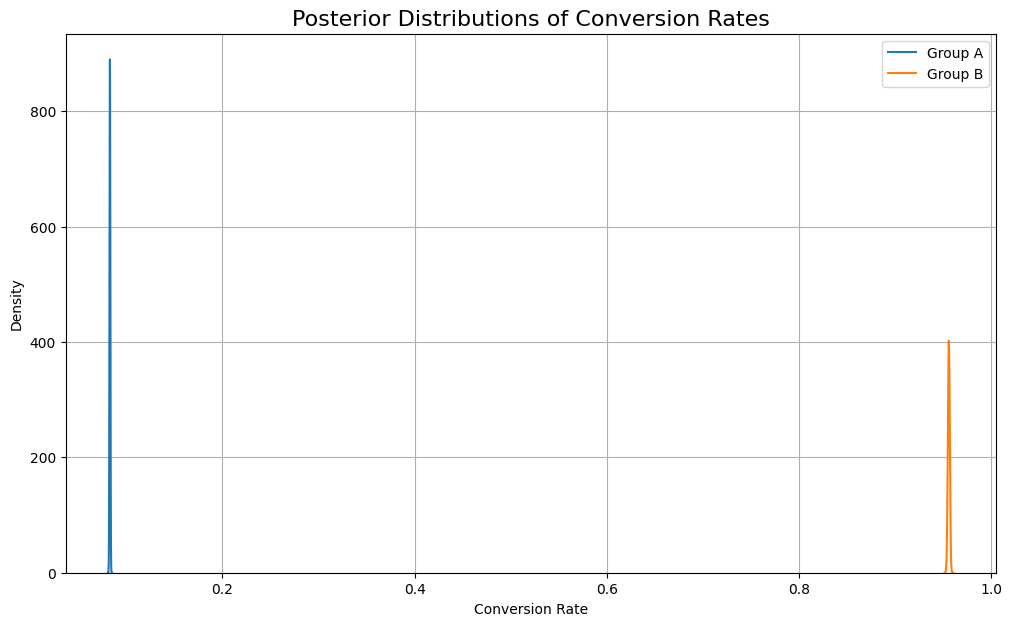



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to Check Owner CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,8339,385312,2.16%
1,B,2240,42586,5.26%




✅ Z-test (2 groups)
- Z statistic: -39.0405
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 1522.8795
- p-value: 0.0000



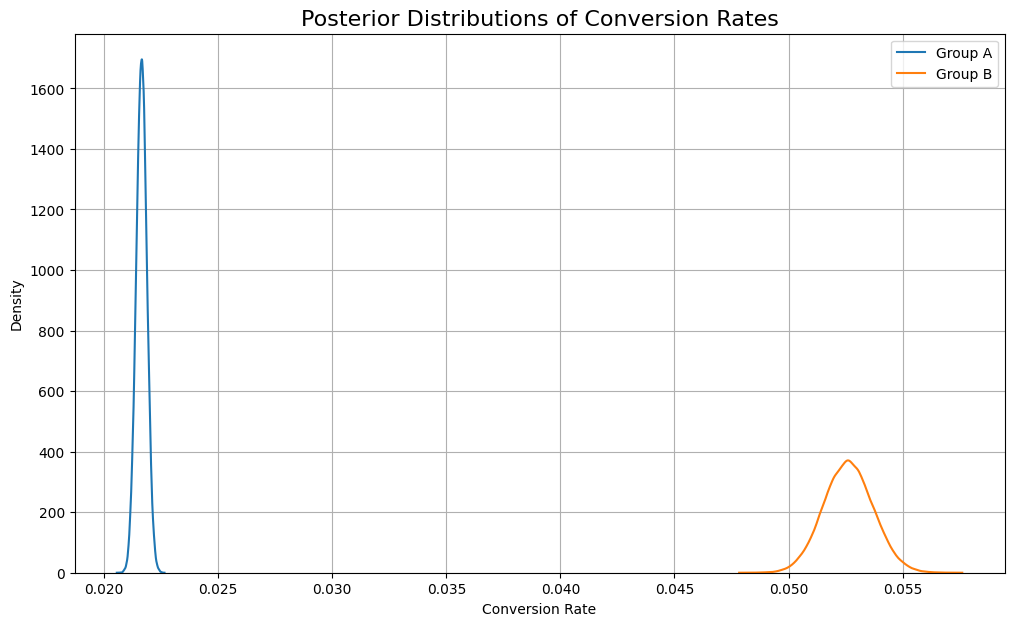



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to Try MyGarage CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,7152,385312,1.86%
1,B,1711,42586,4.02%




✅ Z-test (2 groups)
- Z statistic: -29.7213
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 882.2930
- p-value: 0.0000



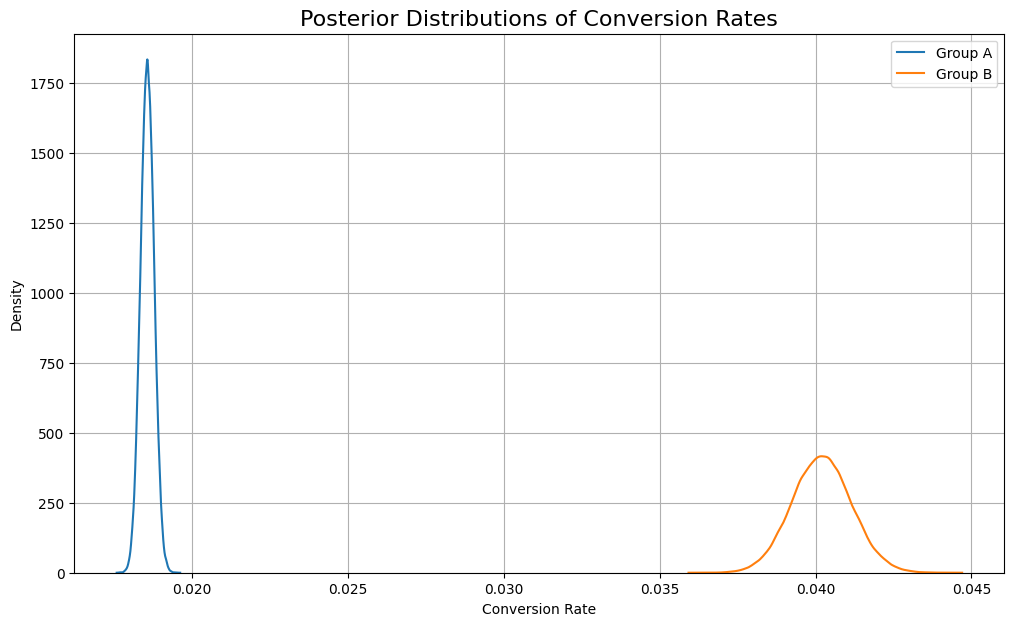



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to MyCar Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,6582,385312,1.71%
1,B,1535,42586,3.60%




✅ Z-test (2 groups)
- Z statistic: -27.2204
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 739.9335
- p-value: 0.0000



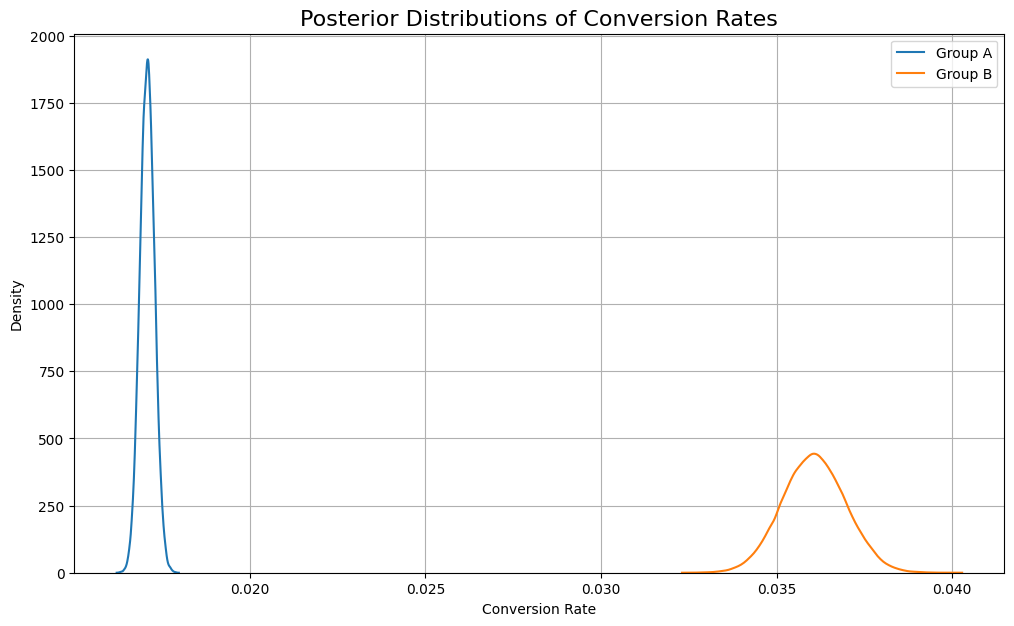



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to Request a Estimate Complete CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,631,385312,0.16%
1,B,71,42586,0.17%




✅ Z-test (2 groups)
- Z statistic: -0.1431
- p-value: 0.8862


✅ Chi-square Test (2x2)
- Chi2 statistic: 0.0064
- p-value: 0.9362



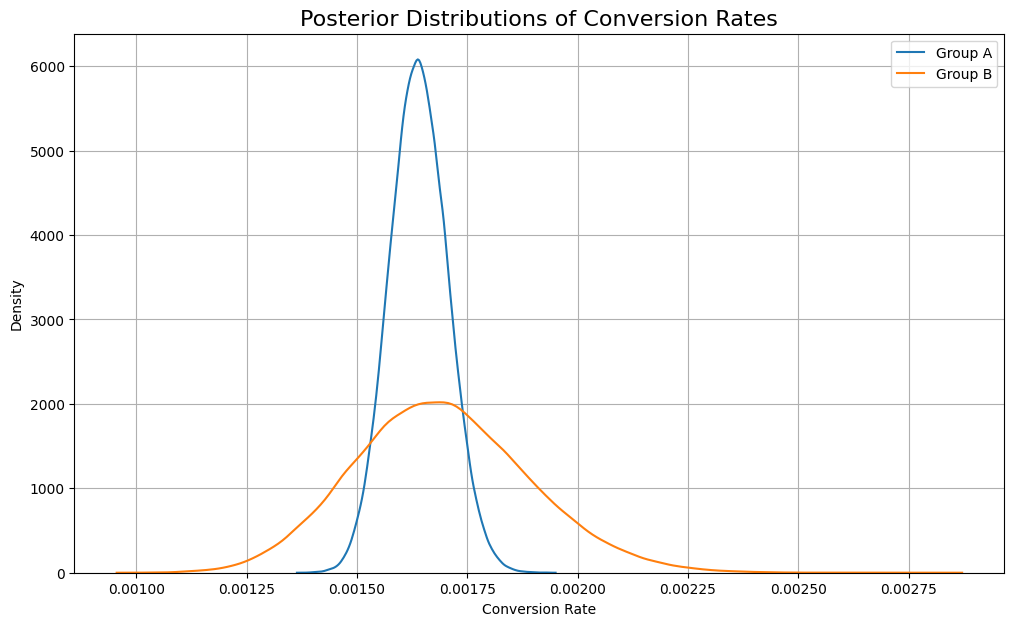



✅ Bayesian: Probability that each group is best
Probability that A is the best: 41.34%
Probability that B is the best: 58.66%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.4133,0.5867




######################################################################
📊 Total PCID to Buy Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,309623,385312,80.36%
1,B,32054,42586,75.27%




✅ Z-test (2 groups)
- Z statistic: 24.8374
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 616.5796
- p-value: 0.0000



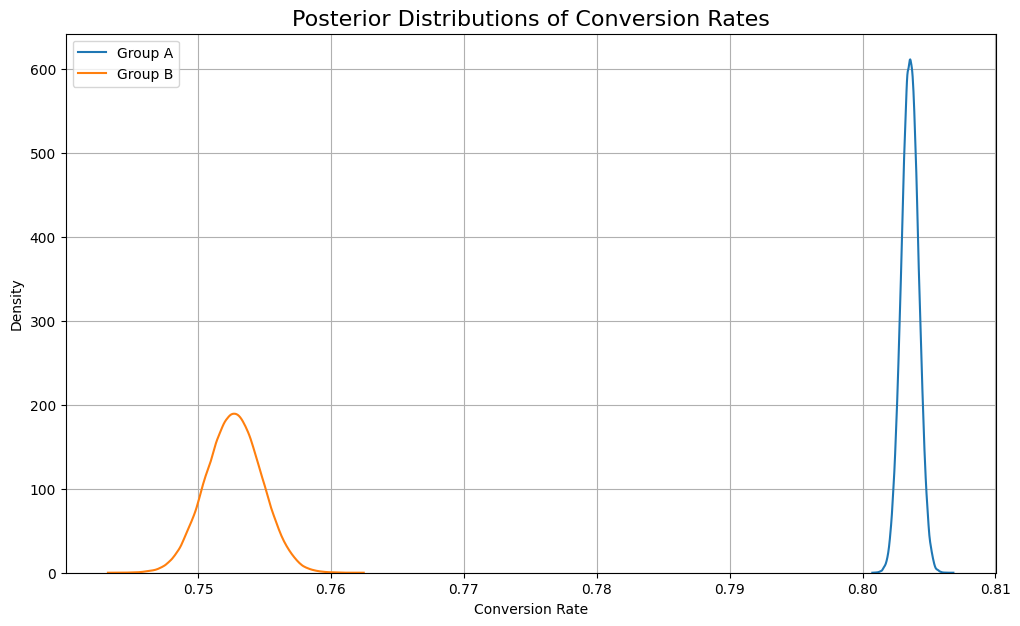



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Total PCID to Search Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,336439,385312,87.32%
1,B,35679,42586,83.78%




✅ Z-test (2 groups)
- Z statistic: 20.5595
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 422.3804
- p-value: 0.0000



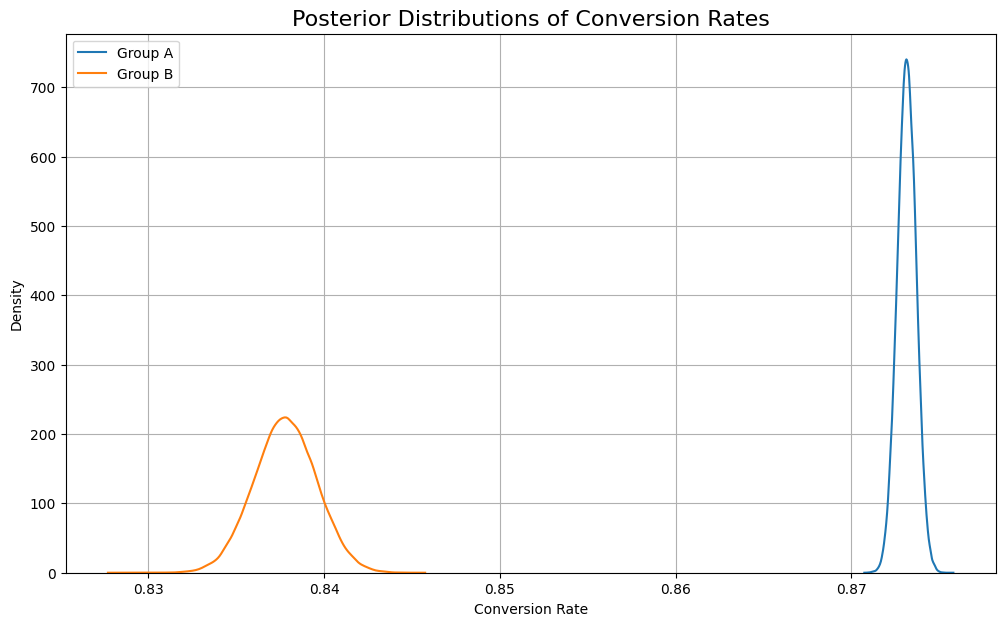



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Total PCID to Car Detail CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,283457,385312,73.57%
1,B,30606,42586,71.87%




✅ Z-test (2 groups)
- Z statistic: 7.5200
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 56.4633
- p-value: 0.0000



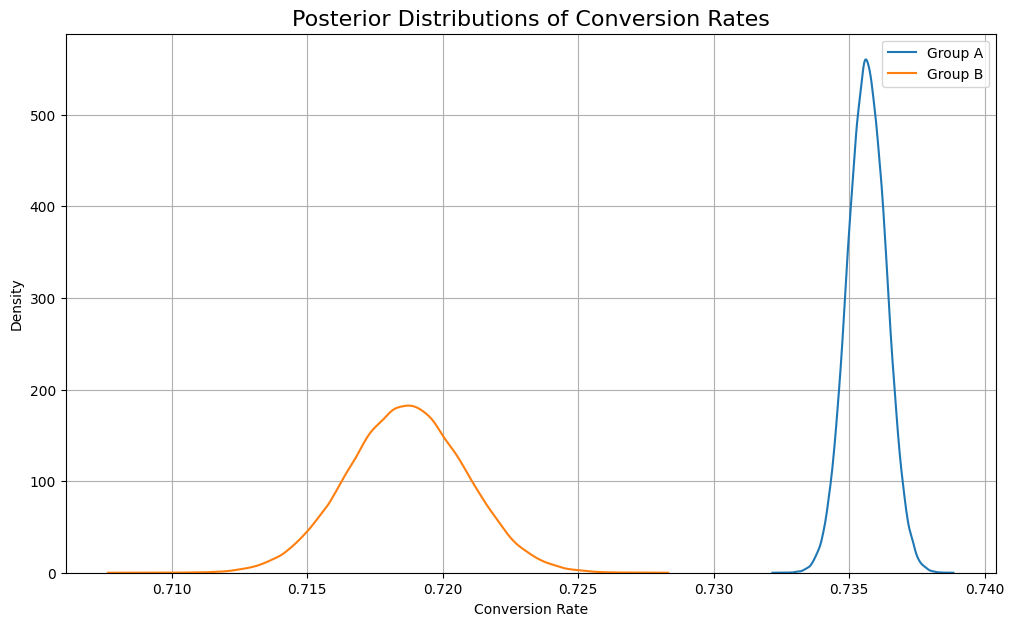



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Total PCID to Contact Click CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,6711,385312,1.74%
1,B,725,42586,1.70%




✅ Z-test (2 groups)
- Z statistic: 0.5885
- p-value: 0.5562


✅ Chi-square Test (2x2)
- Chi2 statistic: 0.3237
- p-value: 0.5694



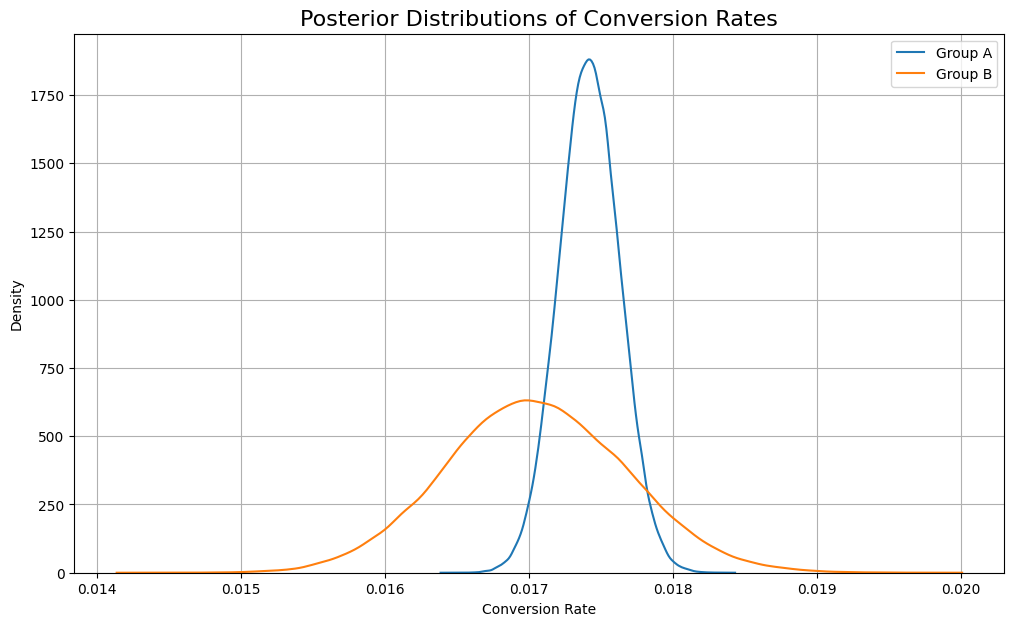



✅ Bayesian: Probability that each group is best
Probability that A is the best: 71.46%
Probability that B is the best: 28.54%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.7146,0.2854


In [7]:
# Test group 작성
groups = ['A', 'B']

# 각 이벤트 별 실험 결과 정리
TOTAL_PCID = np.array([385312, 42586])
TOTAL_EVENT = np.array([277322522, 30418540])
SELL_HOME = np.array([32007, 40703])
CHECK_OWNER = np.array([8339, 2240])
TRY_MYGARAGE = np.array([7152, 1711])
MYCAR_HOME_ING = np.array([6582, 1535])
ESTIMATE_COMPLETE = np.array([631, 71])
BUY_HOME = np.array([309623, 32054])
SEARCH_HOME = np.array([336439, 35679])
CAR_DETAIL = np.array([283457, 30606])
CAR_DETAIL_CONTACT = np.array([6711, 725])

# AB test 3그룹 이상 인 경우 abtest_multi() 사용
# abtest_multi(groups, successes, trials, metric_name="")
# Metric 별 작성

# 내차팔기 metric
# 0. 실험참여자 전체 -> 내차팔기 홈 진입 CVR
abtest_auto(groups, SELL_HOME, TOTAL_PCID, metric_name="Total PCID to Sell Home CVR")
# 1. 실험참여자 전체 -> 소유자명 확인 페이지 CVR
abtest_auto(groups, CHECK_OWNER, TOTAL_PCID, metric_name="Total PCID to Check Owner CVR")
# 2. 실험참여자 전체 -> 차량정보확인중 (내차고등록시도) CVR
abtest_auto(groups, TRY_MYGARAGE, TOTAL_PCID, metric_name="Total PCID to Try MyGarage CVR")
# 3. 실험참여자 전체 -> 내차고 홈 CVR
abtest_auto(groups, MYCAR_HOME_ING, TOTAL_PCID, metric_name="Total PCID to MyCar Home CVR")
# 4. 실험참여자 전체 -> 비교견적 신청 완료 CVR
abtest_auto(groups, ESTIMATE_COMPLETE, TOTAL_PCID, metric_name="Total PCID to Request a Estimate Complete CVR")

# 내차사기 metric
# 5. 실험참여자 전체 -> 내차사기 홈 CVR
abtest_auto(groups, BUY_HOME, TOTAL_PCID, metric_name="Total PCID to Buy Home CVR")
# 6. 실험참여자 전체 -> 검색 홈 CVR
abtest_auto(groups, SEARCH_HOME, TOTAL_PCID, metric_name="Total PCID to Search Home CVR")
# 7. 실험참여자 전체 -> 차량상세 CVR
abtest_auto(groups, CAR_DETAIL, TOTAL_PCID, metric_name="Total PCID to Car Detail CVR")
# 8. 실험참여자 전체 -> 문의하기 클릭 CVR
abtest_auto(groups, CAR_DETAIL_CONTACT, TOTAL_PCID, metric_name="Total PCID to Contact Click CVR")

# 2-3. 전 Funnel 의 전환율 지표 계산


######################################################################
📊 Check car number to Check Owner CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,8339,32007,26.05%
1,B,2240,40703,5.50%




✅ Z-test (2 groups)
- Z statistic: 78.0147
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 6084.6416
- p-value: 0.0000



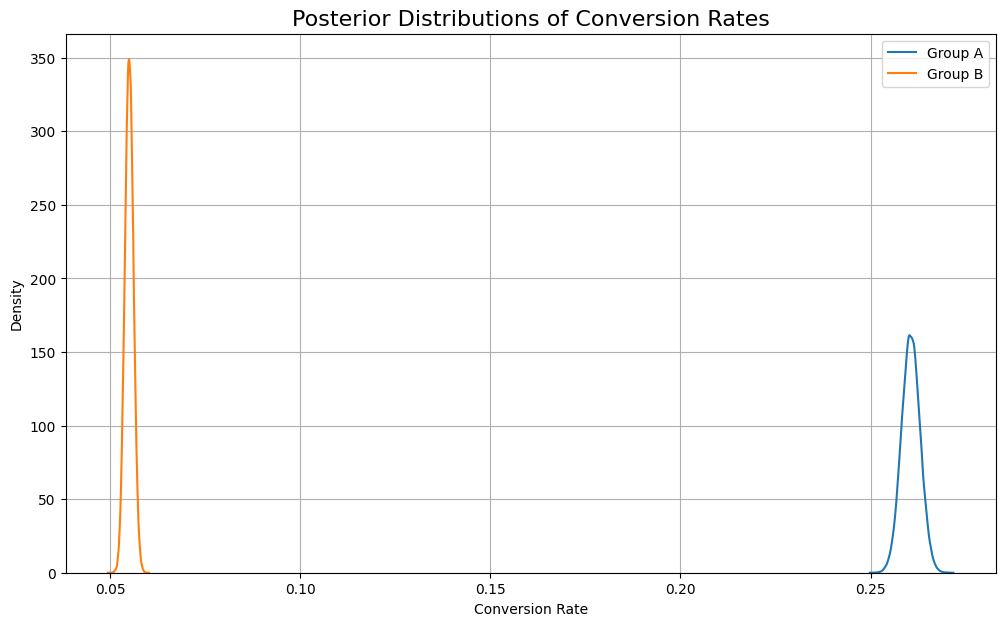



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 MY GARAGE to Request a Estimate Complete CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,631,6582,9.59%
1,B,71,1535,4.63%




✅ Z-test (2 groups)
- Z statistic: 6.2274
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 38.1550
- p-value: 0.0000



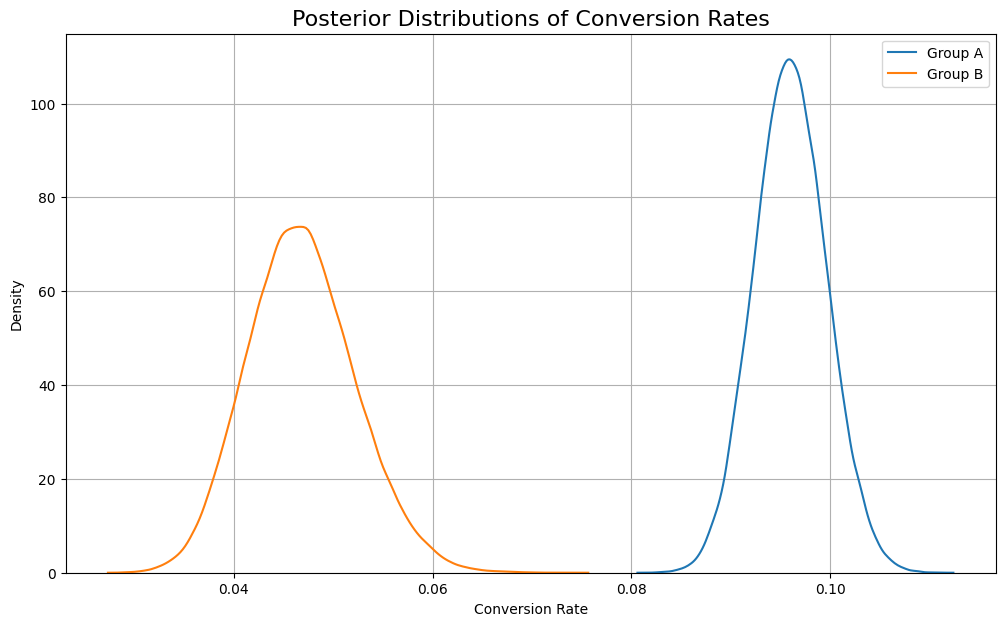



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Buy Home to Car Detail CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,283457,309623,91.55%
1,B,30606,32054,95.48%




✅ Z-test (2 groups)
- Z statistic: -24.5967
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 604.4680
- p-value: 0.0000



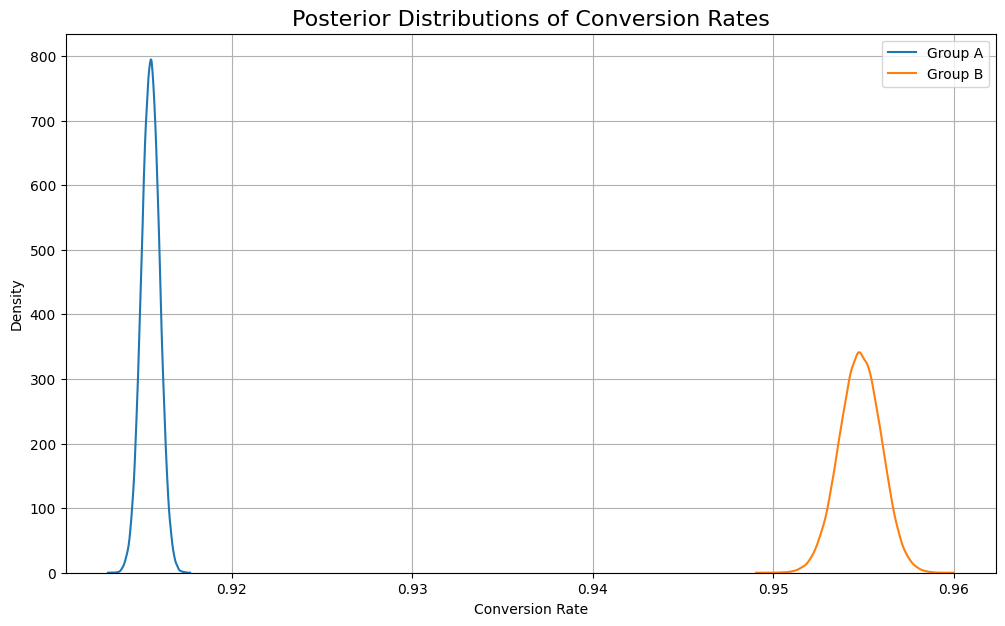



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Car Detail to Contact Click CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,6711,283457,2.37%
1,B,725,30606,2.37%




✅ Z-test (2 groups)
- Z statistic: -0.0138
- p-value: 0.9890


✅ Chi-square Test (2x2)
- Chi2 statistic: 0.0000
- p-value: 1.0000



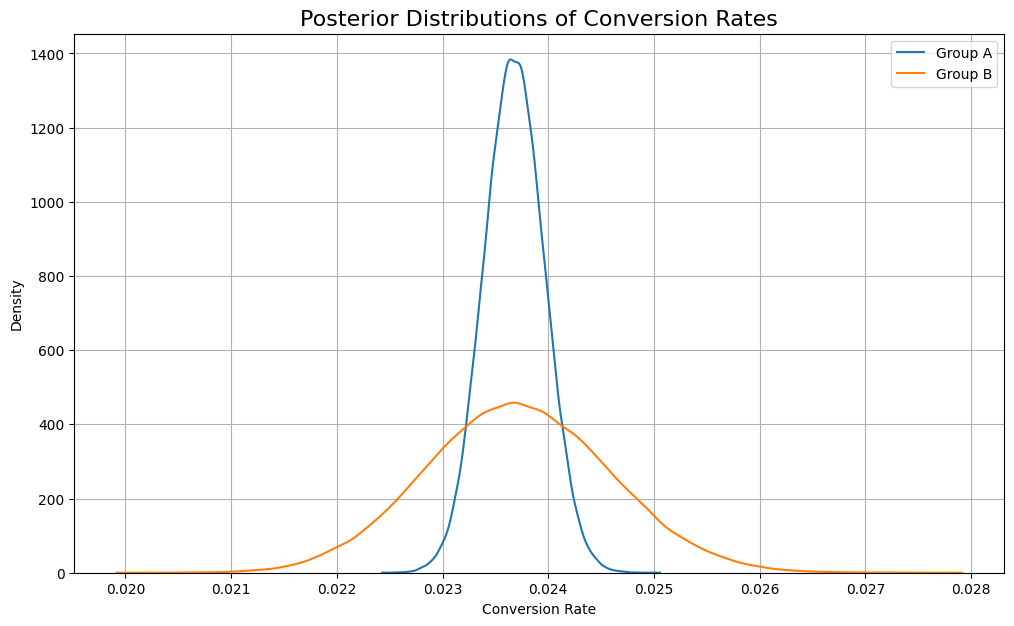



✅ Bayesian: Probability that each group is best
Probability that A is the best: 48.76%
Probability that B is the best: 51.24%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.4876,0.5124




######################################################################
📊 Buy Home to Contact Click CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,6711,309623,2.17%
1,B,725,32054,2.26%




✅ Z-test (2 groups)
- Z statistic: -1.1019
- p-value: 0.2705


✅ Chi-square Test (2x2)
- Chi2 statistic: 1.1702
- p-value: 0.2794



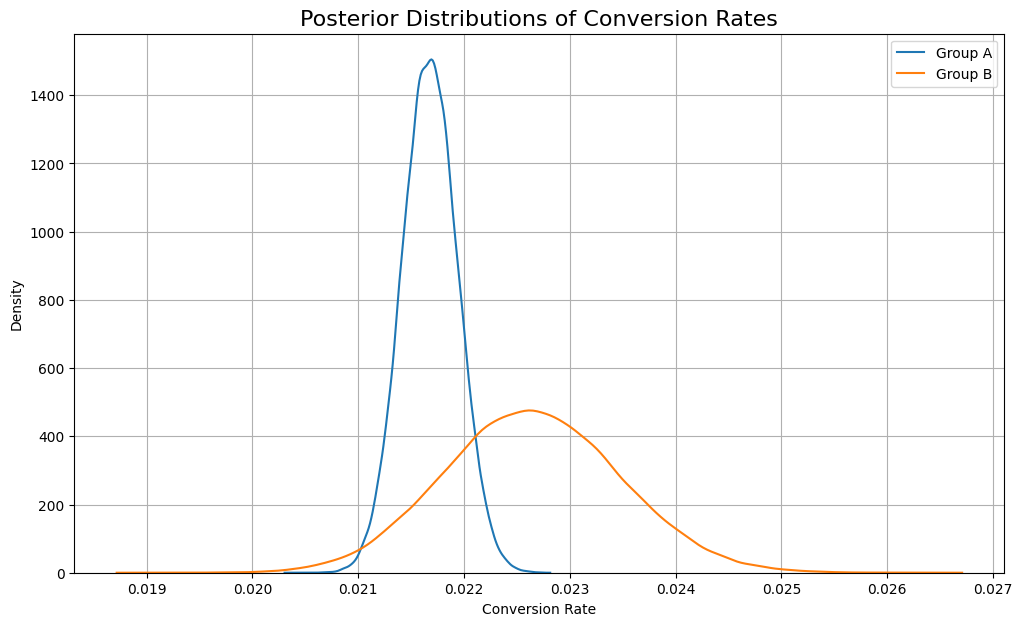



✅ Bayesian: Probability that each group is best
Probability that A is the best: 13.29%
Probability that B is the best: 86.71%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.1329,0.8671


In [8]:
# Test group 작성
groups = ['A', 'B']

# 각 이벤트 별 실험 결과 정리
TOTAL_PCID = np.array([385312, 42586])
TOTAL_EVENT = np.array([277322522, 30418540])
SELL_HOME = np.array([32007, 40703])
CHECK_OWNER = np.array([8339, 2240])
TRY_MYGARAGE = np.array([7152, 1711])
MYCAR_HOME_ING = np.array([6582, 1535])
ESTIMATE_COMPLETE = np.array([631, 71])
BUY_HOME = np.array([309623, 32054])
SEARCH_HOME = np.array([336439, 35679])
CAR_DETAIL = np.array([283457, 30606])
CAR_DETAIL_CONTACT = np.array([6711, 725])

# AB test 3그룹 이상 인 경우 abtest_multi() 사용
# abtest_multi(groups, successes, trials, metric_name="")
# Metric 별 작성

# 내차사기 metric
# 1. 번호판 조회 -> 소유자명 CVR
abtest_auto(groups, CHECK_OWNER, SELL_HOME, metric_name="Check car number to Check Owner CVR")
# 2. 내차고 홈 -> 비교견적 신청 완료 CVR
abtest_auto(groups, ESTIMATE_COMPLETE, MYCAR_HOME_ING, metric_name="MY GARAGE to Request a Estimate Complete CVR")

# 내차사기 metric
# 3. 내차사기 홈 -> 차량상세 CVR
abtest_auto(groups, CAR_DETAIL, BUY_HOME, metric_name="Buy Home to Car Detail CVR")
# 4. 차량상세 -> 문의하기 클릭 CVR
abtest_auto(groups, CAR_DETAIL_CONTACT, CAR_DETAIL, metric_name="Car Detail to Contact Click CVR")
# 5. 내차사기 홈 -> 문의하기 클릭 CVR
abtest_auto(groups, CAR_DETAIL_CONTACT, BUY_HOME, metric_name="Buy Home to Contact Click CVR")